## Flood prediction

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

%load_ext autoreload
%autoreload 2

from utils.utils import remove_duplicates, compute_metrics, init_logging, get_null_count

init_logging()

from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output="pandas")

rds = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
from scoring.scores import SCORES
from sklearn.metrics import make_scorer

def score_fn(y_true, y_pred):
    score = sum(
        SCORES[pred - 1, true - 1] for pred, true in zip(np.round(y_pred, 0).astype(int) + 1, y_true + 1)
    )
    return score

custom_scorer = make_scorer(score_func=score_fn, greater_is_better=True)


In [436]:
def classifier_scorer(y, predictions):
    """Should take discrete outputs 0 indexed"""
    return sum(SCORES[pred, true] for pred, true in zip(predictions.astype(int), y.astype(int)))

In [382]:
df_labelled = pd.read_csv("../flood_tool/resources/postcodes_labelled.csv")
df_unlabelled = pd.read_csv("../flood_tool/resources/postcodes_unlabelled.csv")
df_stacked = pd.concat(
[df_unlabelled, df_labelled[df_unlabelled.columns]], ignore_index=True
)

In [419]:
df_labelled

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130,Oldham,1,119100.0,False
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130,Walsall,1,84200.0,False
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60,Leeds,1,134900.0,False
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120,Tameside,1,170200.0,False
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20,Stockton-on-Tees,1,190600.0,False
...,...,...,...,...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160,Leeds,1,NaN,False
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40,Stockport,1,328700.0,False
29997,HD7 4PA,409215,416819,Cambisols,310,Kirklees,1,214500.0,False
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130,Gateshead,1,273100.0,False


In [422]:
os = df_labelled[['easting', 'northing']]

In [443]:
easting = df_labelled.easting
northing = df_labelled.northing

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,NaN,390978,403269,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,396607,298083,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,427859,432937,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,395560,397900,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,445771,515362,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
29995,NaN,425977,438923,NaN,NaN,NaN,NaN,NaN,NaN
29996,NaN,384808,387982,NaN,NaN,NaN,NaN,NaN,NaN
29997,NaN,409215,416819,NaN,NaN,NaN,NaN,NaN,NaN
29998,NaN,419672,560517,NaN,NaN,NaN,NaN,NaN,NaN


In [444]:
labels = df_labelled.sort_values(by='postcode').riskLabel

In [403]:
postcodes = df_labelled.postcode.tolist()
X = df_stacked[df_stacked["postcode"].isin(postcodes)].copy().drop_duplicates()


In [406]:
X.sort_values(by='postcode', inplace=True)

In [407]:
df_stacked

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
39995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
39996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
39997,HD7 4PA,409215,416819,Cambisols,310
39998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [408]:
X == df_labelled

ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects

In [427]:
from flood_tool.data_processor import DataProcessor
dp = DataProcessor(
    df_postcodes=df_labelled,
    resource_path='../flood_tool/resources/'
)

2023-11-23 17:05:17,399 [flood_tool.data_processor] INFO: Data loaded successfully loaded.


In [428]:
df_os = dp.process_os(easting, northing)

In [432]:
df_os.sort_values(by='postcode')

,x,y,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded,latitude,longitude
22328,406828,286519,B1 1BN,406828,286519,Unsurveyed/Urban,120,Birmingham,1,242100.0,False,52.476557,-1.900901
15724,406827,286134,B1 1DW,406827,286134,Unsurveyed/Urban,130,Birmingham,1,258600.0,False,52.473096,-1.900923
7440,406600,286300,B1 1JQ,406600,286300,Unsurveyed/Urban,140,Birmingham,1,238000.0,False,52.474591,-1.904262
22175,406600,286300,B1 1JQ,406600,286300,Unsurveyed/Urban,140,Birmingham,1,238000.0,False,52.474591,-1.904262
9712,406543,286230,B1 1JS,406543,286230,Unsurveyed/Urban,140,Birmingham,1,255700.0,False,52.473963,-1.905102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23417,460681,430444,YO8 9RL,460681,430444,Gleysols,10,Selby,2,206500.0,False,53.766817,-1.080906
15583,459985,430870,YO8 9TH,459985,430870,Unsurveyed/Urban,10,Selby,6,218500.0,False,53.770726,-1.091381
28925,461173,430045,YO8 9UL,461173,430045,Gleysols,10,Selby,1,207900.0,False,53.763174,-1.073522
7727,454977,430481,YO8 9ZB,454977,430481,Arenosols,10,Selby,1,247700.0,False,53.767781,-1.167422


In [445]:
preds = tool.predict_flood_class_from_OSGB36_location(easting, northing)

2023-11-23 17:14:24,208 [flood_tool.tool] INFO: (76944, 9)


In [438]:
classifier_scorer(labels -1, preds -1)x

2281790

In [431]:
df_labelled.sort_values(by='postcode')

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
22328,B1 1BN,406828,286519,Unsurveyed/Urban,120,Birmingham,1,242100.0,False
15724,B1 1DW,406827,286134,Unsurveyed/Urban,130,Birmingham,1,258600.0,False
7440,B1 1JQ,406600,286300,Unsurveyed/Urban,140,Birmingham,1,238000.0,False
9712,B1 1JS,406543,286230,Unsurveyed/Urban,140,Birmingham,1,255700.0,False
12486,B1 1LN,406764,286406,Unsurveyed/Urban,130,Birmingham,1,224300.0,False
...,...,...,...,...,...,...,...,...,...
23417,YO8 9RL,460681,430444,Gleysols,10,Selby,2,206500.0,False
15583,YO8 9TH,459985,430870,Unsurveyed/Urban,10,Selby,6,218500.0,False
28925,YO8 9UL,461173,430045,Gleysols,10,Selby,1,207900.0,False
7727,YO8 9ZB,454977,430481,Arenosols,10,Selby,1,247700.0,False


In [421]:
dp.get_combined_dataframe()

2023-11-23 16:33:31,930 [flood_tool.data_processor] INFO: Data successfully merged.


,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded,latitude,...,typicalRangeLow,typical_average_rainfall_per_hour,wet_average_rainfall_per_hour,postcodeDistrict,catsPerHousehold,dogsPerHousehold,postcodeSector,households,numberOfPostcodeUnits,headcount
0,OL9 7NS,390978.0,403269.0,Unsurveyed/Urban,130.0,Oldham,1.0,119100.0,False,53.526004,...,NaN,0.0,0.741667,OL9,0.151213,0.173414,OL9 7,NaN,NaN,NaN
1,OL9 7DX,390874.0,403827.0,Unsurveyed/Urban,130.0,Oldham,1.0,110600.0,False,53.531018,...,NaN,0.0,0.741667,OL9,0.151213,0.173414,OL9 7,NaN,NaN,NaN
2,OL9 7AZ,391300.0,404000.0,Unsurveyed/Urban,150.0,Oldham,1.0,130200.0,False,53.532580,...,NaN,0.0,0.741667,OL9,0.151213,0.173414,OL9 7,NaN,NaN,NaN
3,OL9 7LY,390603.0,402883.0,Unsurveyed/Urban,110.0,Oldham,1.0,112900.0,False,53.522528,...,NaN,0.0,0.741667,OL9,0.151213,0.173414,OL9 7,NaN,NaN,NaN
4,OL9 7DF,391172.0,403860.0,Unsurveyed/Urban,140.0,Oldham,1.0,124300.0,False,53.531320,...,NaN,0.0,0.741667,OL9,0.151213,0.173414,OL9 7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,S96 5XX,437927.0,389870.0,Unsurveyed/Urban,40.0,Sheffield,1.0,NaN,True,53.404293,...,NaN,0.0,3.091667,S96,0.000000,0.000000,S96 5,NaN,NaN,NaN
29996,CB6 1EH,558563.0,292514.0,Gleysols,0.0,King's Lynn and West Norfolk,8.0,276000.0,False,52.507462,...,NaN,0.0,0.000000,CB6,0.296852,0.340437,CB6 1,NaN,NaN,NaN
29997,CW9 6NF,368821.0,378786.0,Stagnosols,50.0,Cheshire East,1.0,394600.0,False,53.305093,...,NaN,0.0,1.529167,CW9,0.230472,0.264310,CW9 6,NaN,NaN,NaN
29998,CW9 6LZ,367292.0,380886.0,Stagnosols,60.0,Cheshire East,1.0,382200.0,False,53.323876,...,NaN,0.0,1.529167,CW9,0.230472,0.264310,CW9 6,NaN,NaN,NaN


In [410]:
feats = ['postcode', 'easting', 'northing', 'soilType', 'elevation']

In [411]:
from flood_tool.models.flood_predictor import FloodPredictor


In [440]:
fp = FloodPredictor(
    training_data=df_labelled,
    model_alias='xgb_regressor',
    scoring=score_fn,
)
fp.test_score

2023-11-23 17:10:52,131 [flood_tool.models.flood_predictor] ERROR: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2023-11-23 17:10:52,132 [flood_tool.models.flood_predictor] ERROR: <class 'pandas.core.series.Series'>
2023-11-23 17:10:52,616 [flood_tool.models.predictor] INFO: Model successfully fit.


{'flood_score': 569980}

In [442]:
preds = fp.predict_flood_risk(df_labelled[feats], index=('easting', 'northing'))

/Users/bpg23/Documents/GitHub/ads-deluge-wye/flood_tool/models/flood_predictor.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=list(index), inplace=True)
/Users/bpg23/Documents/GitHub/ads-deluge-wye/flood_tool/models/flood_predictor.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"x": index[0], "y": index[1]}, inplace=True)


KeyError: 'easting'

In [414]:
preds.value_counts()

predictions
1     27144
2       688
3       534
6       433
4       368
8       313
5       299
7       154
9        39
10       28
Name: count, dtype: int64

In [415]:
def classifier_scorer(y, predictions):
    """Should take discrete outputs 0 indexed"""
    return sum(SCORES[pred, true] for pred, true in zip(predictions.astype(int), y.astype(int)))

In [416]:
df_labelled.riskLabel.value_counts()

riskLabel
1     28124
6       691
8       484
7       182
4       163
5       115
9        65
3        61
10       58
2        57
Name: count, dtype: int64

In [418]:
classifier_scorer(labels - 1, preds -1)

3672990

In [350]:
from flood_tool.tool import Tool
tool = Tool()

2023-11-23 16:07:33,135 [flood_tool.data_processor] INFO: Data loaded successfully loaded.
2023-11-23 16:07:33,330 [flood_tool.data_processor] INFO: Data loaded successfully loaded.


In [351]:
X = tool.predict_flood_class_from_postcode(test_labels, method='xgb_regressor')

2023-11-23 16:07:34,233 [flood_tool.tool] INFO: (30000, 5)
2023-11-23 16:07:35,008 [flood_tool.models.flood_predictor] ERROR: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2023-11-23 16:07:35,009 [flood_tool.models.flood_predictor] ERROR: <class 'pandas.core.series.Series'>
2023-11-23 16:07:35,692 [flood_tool.models.predictor] INFO: Model successfully fit.
2023-11-23 16:07:35,692 [flood_tool.tool] INFO: xgb_regressor test: {'flood_score': 570760}


In [352]:
df_labelled

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130,Oldham,1,119100.0,False
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130,Walsall,1,84200.0,False
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60,Leeds,1,134900.0,False
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120,Tameside,1,170200.0,False
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20,Stockton-on-Tees,1,190600.0,False
...,...,...,...,...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160,Leeds,1,NaN,False
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40,Stockport,1,328700.0,False
29997,HD7 4PA,409215,416819,Cambisols,310,Kirklees,1,214500.0,False
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130,Gateshead,1,273100.0,False


In [354]:
preds2 = tool.predict_flood_class_from_postcode(test_labels, method='xgb_regressor')
classifier_scorer(df_labelled.riskLabel - 1, preds -1), classifier_scorer(df_labelled.riskLabel - 1, preds2 -1)


2023-11-23 16:08:55,733 [flood_tool.tool] INFO: (30000, 5)
2023-11-23 16:08:56,671 [flood_tool.models.flood_predictor] ERROR: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2023-11-23 16:08:56,672 [flood_tool.models.flood_predictor] ERROR: <class 'pandas.core.series.Series'>
2023-11-23 16:08:57,248 [flood_tool.models.predictor] INFO: Model successfully fit.
2023-11-23 16:08:57,248 [flood_tool.tool] INFO: xgb_regressor test: {'flood_score': 569980}


(3672990, 2170610)

In [314]:
preds2.shape

(30000,)

In [315]:
preds.shape

(30000,)

In [316]:
preds2.value_counts()

predictions
1     27144
2       688
3       534
6       433
4       368
8       313
5       299
7       154
9        39
10       28
Name: count, dtype: int64

In [317]:
preds.value_counts()

predictions
1     27144
2       688
3       534
6       433
4       368
8       313
5       299
7       154
9        39
10       28
Name: count, dtype: int64

In [318]:
classifier_scorer(df_labelled.riskLabel - 1, preds -1), classifier_scorer(df_labelled.riskLabel - 1, preds2 -1)

(3672990, 3672990)

In [178]:
remove_duplicates(df)

2023-11-23 15:50:22,828 [utils.utils] INFO: Dropped 0 duplicates.


In [1034]:
feats

Index(['postcode', 'easting', 'northing', 'soilType', 'elevation'], dtype='object')

In [1035]:
X = df.drop(columns = 'riskLabel')[feats]
y = df.riskLabel
y -= 1

In [994]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = rds, stratify=y)

In [907]:
# y_train_sub = y_train - 1
# y_test_sub = y_test - 1

### Separate numerical and categorical data

In [222]:
num_cols = X_train.select_dtypes(include=np.number).columns
cat_cols = X_train.select_dtypes(exclude=np.number).columns

In [223]:
num_cols

Index(['easting', 'northing', 'elevation'], dtype='object')

In [224]:
cat_cols = ['soilType']

## Make pipelines

In [225]:
get_null_count(X_train)

2023-11-21 17:19:53,072 [utils.utils] INFO: Null count: 0


In [226]:



from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(lambda df: pd.DataFrame(np.log(df + 1e-10), index=df.index, columns=df.columns))

negative_transformer = FunctionTransformer(lambda df: pd.DataFrame(np.where(df < 0, 1e-10, df), index=df.index, columns=df.columns))

num_pipe = Pipeline(
    steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ]
)

num_log_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('log', log_transformer),
        ('scaler', StandardScaler())
    ]
)


cat_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        # ('num_log', num_log_pipe, num_log_cols),
        ('cat', cat_pipe, cat_cols),
    ]
)

In [227]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['easting', 'northing', 'elevation'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['soilType'])])

In [228]:
X_train_prep = preprocessor.fit_transform(X_train)

## Full pipe

In [229]:
from xgboost import XGBRegressor

model_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=rds)),
    ]
)

In [230]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## Model training

Custom scoring function to maximise

In [1151]:
from scoring.scores import SCORES
from sklearn.metrics import make_scorer

def score_fn(y_true, y_pred):
    score = sum(
        SCORES[pred - 1, true - 1] for pred, true in zip(np.round(y_pred, 0).astype(int) + 1, y_true + 1)
    )
    return score

custom_scorer = make_scorer(score_func=score_fn, greater_is_better=True)


In [232]:
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('scaler', StandardScaler())]),
                                    Index(['easting', 'northing', 'elevation'], dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    ['soilType'])])),
  ('model',
   XGBRegressor(base_score=None, booster=None, callbacks=Non

In [233]:
model_pipe.fit(X_train, y_train_sub) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [234]:
y_train_sub

8249     0
11163    0
12718    0
9149     0
22634    0
        ..
27917    0
19809    0
1183     0
17235    0
25414    0
Name: riskLabel, Length: 24000, dtype: int64

In [235]:
y_preds = model_pipe.predict(X_test)

In [236]:
score = score_fn(y_test_sub, y_preds)
score

559450

In [237]:
import scipy.stats as stats

param_distribution = {
    'preprocessor__num__scaler':  [StandardScaler(), MinMaxScaler()],
    'model__learning_rate': stats.uniform(0.01, 0.9),
    'model__n_estimators': stats.randint(500, 1000),
    'model__max_depth': stats.randint(30, 60),
}



In [238]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

rand_cv = RandomizedSearchCV(
    estimator=model_pipe, 
    param_distributions=param_distribution, 
    scoring=custom_scorer, 
    cv=StratifiedKFold(n_splits=5, shuffle=False).split(X_train, y=y_train), 
    n_iter=50,
    n_jobs=-1, 
    random_state=rds
)



In [239]:
rand_cv.fit(X_train, y_train_sub)

/opt/homebrew/anaconda3/envs/deluge-wye/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x17f74a8c0>,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImput...
                   param_distributions={'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28e2b1f10>,
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28cf2fa10>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28912f550>,
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler()]},
                   random_state=42, scoring=make_scorer(score_fn))

In [240]:
rand_cv.best_score_

457992.0

In [401]:
rand_cv.best_params_

{'model__learning_rate': 0.7750347200108194,
 'model__max_depth': 41,
 'model__n_estimators': 917,
 'preprocessor__num__scaler': StandardScaler()}

In [348]:
best_model = rand_cv.best_estimator_

In [349]:
y_preds = best_model.predict(X_test)
score = score_fn(y_test_sub, y_preds)
score

569000

## Clipping results

In [350]:
y_preds = np.round(y_preds)

In [351]:
y_preds_clipped = np.clip(y_preds, 0, y_preds.max())

In [352]:
np.sum(y_preds_clipped == -1)

0

In [353]:
y_preds = y_preds_clipped + 1

In [354]:
np.sum(y_preds == 0)

0

In [347]:
np.unique(np.round(y_preds, 0))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], dtype=float32)

## Class implementation test

In [270]:
from flood_tool.models.flood_predictor import FloodPredictor

In [271]:
fp = FloodPredictor(
    path='../flood_tool/resources/postcodes_labelled.csv',
    scoring=score_fn,
    tune_hyperparameters=False,
    n_iter=15,
)

2023-11-21 17:24:33,943 [flood_tool.models.predictor] INFO: Model successfully fit.


In [272]:
fp.predict_test()

{'flood_score': 559450}

In [273]:
fp.model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['easting', 'northing',
                                                   'elevation']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['soilTy...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [395]:
unlabelled_data = pd.read_csv('../flood_tool/resources/postcodes_unlabelled.csv')
postcodes = unlabelled_data.postcode
from flood_tool.tool import Tool

tool = Tool()

tool.lookup_easting_northing(postcodes=postcodes)
data = tool._postcodedb

In [396]:
data

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [397]:
X = data[data.postcode.isin(postcodes)]


In [398]:
X

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [399]:
preds = fp.model.predict(X)

In [400]:
np.unique(np.round(preds, 0) + 1)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
      dtype=float32)

In [361]:
preds = pd.Series(np.round(preds, 0) + 1, index=X.postcode, name='predictions')

In [362]:
preds

postcode
M34 7QL     1.0
OL4 3NQ     1.0
B36 8TE     2.0
NE16 3AT    2.0
WS10 8DE    1.0
           ... 
NN9 7TY     1.0
HU6 7YG     5.0
LS12 1DY    1.0
DN4 6TZ     1.0
S31 9BD     1.0
Name: predictions, Length: 10000, dtype: float32

In [363]:
preds = fp.predict_from_postcode(postcodes)

In [364]:
preds

postcode
M34 7QL     1.0
OL4 3NQ     1.0
B36 8TE     2.0
NE16 3AT    2.0
WS10 8DE    1.0
           ... 
NN9 7TY     1.0
HU6 7YG     5.0
LS12 1DY    1.0
DN4 6TZ     1.0
S31 9BD     1.0
Name: predictions, Length: 10000, dtype: float32

In [365]:
preds.value_counts()

predictions
1.0    8494
2.0     806
3.0     308
4.0     159
5.0     122
6.0      67
7.0      35
8.0       9
Name: count, dtype: int64

In [385]:
from utils.utils import flood_scoring

fp = FloodPredictor(
    path='../flood_tool/resources/postcodes_labelled.csv',
    scoring=flood_scoring,
    tune_hyperparameters=True,
    n_iter=1,
)

2023-11-21 17:51:12,014 [flood_tool.models.flood_predictor] INFO: Tuning hyperparameters...
2023-11-21 17:51:14,597 [flood_tool.models.predictor] INFO: Model successfully fit.


In [386]:
postcodes

0        M34 7QL
1        OL4 3NQ
2        B36 8TE
3       NE16 3AT
4       WS10 8DE
          ...   
9995     NN9 7TY
9996     HU6 7YG
9997    LS12 1DY
9998     DN4 6TZ
9999     S31 9BD
Name: postcode, Length: 10000, dtype: object

In [388]:
preds = fp.predict_from_postcode(postcodes)

<Axes: >

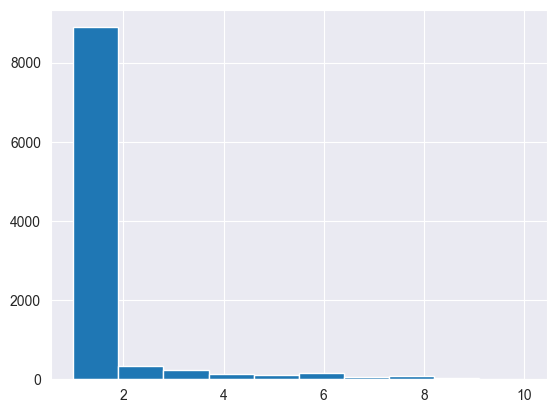

In [394]:
preds.hist(bins=10)

## Preds from lat and lon

In [874]:
fp = FloodPredictor(
    training_path='../flood_tool/resources/postcodes_labelled.csv',
    model_alias='xgb_regressor',
    scoring=score_fn,
    tune_hyperparameters=False,
    n_iter=15,
)

2023-11-22 14:48:07,471 [flood_tool.models.predictor] INFO: Model successfully fit.


In [875]:
fp.predict_test()

{'flood_score': 568940}

In [931]:
unlabelled_data = pd.read_csv('../flood_tool/resources/postcodes_unlabelled.csv')
postcodes = unlabelled_data.postcode
from flood_tool.tool import Tool

tool = Tool()

tool.lookup_easting_northing(postcodes=postcodes)
data = tool._postcodedb

In [932]:
data

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [725]:
from flood_tool.data_processor import DataProcessor


data_processor = DataProcessor(resource_path='../flood_tool/resources', postcodes_path='../flood_tool/resources/postcodes_unlabelled.csv')

In [726]:
X_gps = data_processor.transform_postcodes(keep_os=True)

In [728]:
X_gps

,postcode,easting,northing,soilType,elevation,latitude,longitude
0,M34 7QL,393470,394371,Unsurveyed/Urban,110,53.446063,-2.099783
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210,53.547635,-2.070593
2,B36 8TE,411900,289400,Unsurveyed/Urban,90,52.502371,-1.826124
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10,54.954930,-1.682991
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80,52.273387,-0.708775
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0,53.791500,-0.361201
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40,53.791345,-1.569915
9998,DN4 6TZ,462498,401208,Arenosols,10,53.503859,-1.059207


In [430]:
data_processor.human_data()

,postcode,soilType,elevation,latitude,longitude,nearest_latitude,nearest_longitude,stationReference,stationName,latitude,...,minOnRecord,typicalRangeHigh,typicalRangeLow,postcodeDistrict,catsPerHousehold,dogsPerHousehold,postcodeSector,households,numberOfPostcodeUnits,headcount
0,M34 7QL,Unsurveyed/Urban,110.0,53.446063,-2.099783,53.459311,-2.134747,559969,Rainfall station,53.459311,...,NaN,NaN,NaN,M34,0.206154,0.236422,M34 7,NaN,NaN,NaN
1,M34 7EE,Unsurveyed/Urban,110.0,53.444688,-2.099629,53.459311,-2.134747,559969,Rainfall station,53.459311,...,NaN,NaN,NaN,M34,0.206154,0.236422,M34 7,NaN,NaN,NaN
2,M34 7PS,Unsurveyed/Urban,100.0,53.438963,-2.099104,53.459311,-2.134747,559969,Rainfall station,53.459311,...,NaN,NaN,NaN,M34,0.206154,0.236422,M34 7,NaN,NaN,NaN
3,M34 7PJ,Unsurveyed/Urban,110.0,53.444221,-2.099478,53.459311,-2.134747,559969,Rainfall station,53.459311,...,NaN,NaN,NaN,M34,0.206154,0.236422,M34 7,NaN,NaN,NaN
4,M34 7JX,Unsurveyed/Urban,100.0,53.438481,-2.105320,53.459311,-2.134747,559969,Rainfall station,53.459311,...,NaN,NaN,NaN,M34,0.206154,0.236422,M34 7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,PE99 1AP,Stagnosols,10.0,52.613487,-0.286573,52.632078,-0.313309,E2365,Rainfall station,52.632078,...,NaN,NaN,NaN,PE99,NaN,NaN,PE99 1,NaN,NaN,NaN
9996,WA14 3RU,Stagnosols,40.0,53.359634,-2.395735,53.431001,-2.352893,560557,Rainfall station,53.431001,...,NaN,NaN,NaN,WA14,0.204173,0.234149,WA14 3,1742.0,298.0,4753.0
9997,LE95 2EA,Stagnosols,70.0,52.606175,-1.190561,52.571268,-1.201273,4082,Littlethorpe,52.571268,...,0.279,2.132,0.464,LE95,0.000000,0.000000,LE95 2,NaN,NaN,NaN
9998,DL98 1AF,Unsurveyed/Urban,50.0,54.527510,-1.559700,54.526112,-1.506309,030377,Rainfall station,54.526112,...,NaN,NaN,NaN,DL98,0.000000,0.000000,DL98 1,NaN,NaN,NaN


In [432]:
df_all = data_processor.rainfall()

In [433]:
df_all.columns

Index(['postcode', 'soilType', 'elevation', 'latitude', 'longitude',
       'nearest_latitude', 'nearest_longitude', 'stationReference',
       'stationName', 'latitude', 'longitude', 'maxOnRecord', 'minOnRecord',
       'typicalRangeHigh', 'typicalRangeLow', 'postcodeDistrict',
       'catsPerHousehold', 'dogsPerHousehold', 'postcodeSector', 'households',
       'numberOfPostcodeUnits', 'headcount',
       'typical_average_rainfall_per_hour', 'wet_average_rainfall_per_hour'],
      dtype='object')

In [434]:
df_all.typical_average_rainfall_per_hour.value_counts()

typical_average_rainfall_per_hour
0.000000    5083
0.008333    1094
0.016667     287
0.025000     103
0.004167      71
0.125000      69
0.006667      66
0.033333      41
0.020833      27
0.041667      26
0.025000      22
0.012500      12
0.037500       9
0.075000       8
0.030833       7
0.003750       5
0.054167       5
0.005000       3
0.009583       2
Name: count, dtype: int64

In [438]:
X_os = data_processor.df_postcodes

In [439]:
X_os

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [452]:
X_all = data_processor.level()


In [730]:
X_gps

,postcode,easting,northing,soilType,elevation,latitude,longitude
0,M34 7QL,393470,394371,Unsurveyed/Urban,110,53.446063,-2.099783
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210,53.547635,-2.070593
2,B36 8TE,411900,289400,Unsurveyed/Urban,90,52.502371,-1.826124
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10,54.954930,-1.682991
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80,52.273387,-0.708775
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0,53.791500,-0.361201
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40,53.791345,-1.569915
9998,DN4 6TZ,462498,401208,Arenosols,10,53.503859,-1.059207


## Converting lat and lon to all data

In [731]:
from flood_tool.geo import get_easting_northing_from_gps_lat_long, get_gps_lat_long_from_easting_northing

east, north = get_easting_northing_from_gps_lat_long(X_gps.latitude, X_gps.longitude, rads=False)

In [732]:
df_os = pd.DataFrame(np.c_[np.round(east).astype(int), np.round(north).astype(int)], columns=['easting', 'northing'])

In [733]:
lat, lon = get_gps_lat_long_from_easting_northing(east, north, rads=False)

In [734]:
df_gps = pd.DataFrame(np.c_[lat + 1e-4, lon-1e-4], columns=['latitude', 'longitude']).iloc[:6000, :]

In [735]:
df_gps.shape

(6000, 2)

In [736]:
from scipy.spatial.distance import cdist

distances = cdist(
    df_gps[["latitude", "longitude"]],
    X_gps[["latitude", "longitude"]],
    metric="euclidean",
)
nearest_indices = np.argmin(distances, axis=1)


In [737]:
nearest_features = X_gps.iloc[nearest_indices]

In [738]:
merged_df = pd.concat([df_gps.drop(columns=['latitude', 'longitude']).reset_index(drop=True), nearest_features.reset_index(drop=True)], axis=1)

Now we have postcode we can merge back with easting and northing

In [739]:
merged_df

,postcode,easting,northing,soilType,elevation,latitude,longitude
0,M34 7QL,393470,394371,Unsurveyed/Urban,110,53.446063,-2.099783
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210,53.547635,-2.070593
2,B36 8TE,411900,289400,Unsurveyed/Urban,90,52.502371,-1.826124
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10,54.954930,-1.682991
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...,...,...
5995,BD21 3SQ,406000,441100,Unsurveyed/Urban,110,53.866080,-1.910246
5996,S81 8FL,456118,381378,Planosols,60,53.326354,-1.158907
5997,IP10 0XY,628502,236581,Cambisols,20,51.980670,1.325989
5998,LS16 8HP,427112,440024,Unsurveyed/Urban,140,53.855740,-1.589308


Now we can merge on the nearest distance

In [740]:
data_processor.process_gps(lat + 1e-4, lon-1e-4)

,postcode,easting,northing,soilType,elevation,latitude,longitude
0,M34 7QL,393470,394371,Unsurveyed/Urban,110,53.446063,-2.099783
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210,53.547635,-2.070593
2,B36 8TE,411900,289400,Unsurveyed/Urban,90,52.502371,-1.826124
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10,54.954930,-1.682991
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80,52.273387,-0.708775
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0,53.791500,-0.361201
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40,53.791345,-1.569915
9998,DN4 6TZ,462498,401208,Arenosols,10,53.503859,-1.059207


In [1109]:
from flood_tool.tool import Tool

tool = Tool()

In [1110]:
df_gps = pd.DataFrame(np.c_[lat, lon], columns=['latitude', 'longitude'])
lat = X_gps.latitude
lon = X_gps.longitude

In [1111]:
res = tool.predict_flood_class_from_WGS84_locations(latitudes=lat, longitudes=lon, method='xgb_regressor')

2023-11-22 16:47:01,234 [flood_tool.models.predictor] INFO: Model successfully fit.
2023-11-22 16:47:01,965 [flood_tool.models.flood_predictor] INFO: 737760


In [1114]:
df_stacked = tool.df_stacked

In [1116]:
df_stacked[df_stacked.postcode.isin(X.postcode)].drop_duplicates()

,postcode,easting,northing,soilType,elevation
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20
...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
29997,HD7 4PA,409215,416819,Cambisols,310
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


latitude   longitude
53.446063  -2.099783    1.0
53.547635  -2.070593    1.0
52.502371  -1.826124    1.0
54.954930  -1.682991    1.0
52.567724  -2.034982    1.0
                       ... 
52.273387  -0.708775    1.0
53.791500  -0.361201    6.0
53.791345  -1.569915    1.0
53.503859  -1.059207    1.0
53.304375  -1.375357    1.0
Name: predictions, Length: 10000, dtype: float32

In [830]:
res.value_counts()

predictions
1.0     8886
2.0      306
3.0      252
6.0      141
4.0      133
5.0      116
8.0       78
7.0       65
9.0       13
10.0      10
Name: count, dtype: int64

In [836]:
df_unlabelled[df_unlabelled['postcode'].isin(df_unlabelled.postcode)]

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [797]:
res.value_counts()

predictions
1.0     8886
2.0      306
3.0      252
6.0      141
4.0      133
5.0      116
8.0       78
7.0       65
9.0       13
10.0      10
Name: count, dtype: int64

In [817]:
X_os = tool._postcodedb


In [818]:
eastings = X_os.easting.tolist()
northings = X_os.northing.tolist()


In [819]:
eastings

[393470,
 395420,
 411900,
 420400,
 397726,
 407027,
 510100,
 628083,
 418995,
 500058,
 447714,
 452350,
 427536,
 440070,
 460755,
 408100,
 394103,
 435996,
 442104,
 419195,
 427401,
 418995,
 421560,
 613814,
 651264,
 435446,
 425760,
 406907,
 508400,
 370160,
 430206,
 431010,
 400801,
 460808,
 407084,
 421455,
 431045,
 407117,
 433237,
 411010,
 404729,
 401848,
 483370,
 432990,
 411100,
 469683,
 458767,
 510402,
 454279,
 416200,
 423242,
 636065,
 426833,
 562257,
 404770,
 432912,
 370607,
 481607,
 518199,
 526079,
 404294,
 452372,
 545495,
 458412,
 547523,
 391750,
 425524,
 428177,
 509094,
 411984,
 440435,
 385970,
 388297,
 391853,
 378765,
 459561,
 426500,
 422066,
 416166,
 414570,
 369432,
 440054,
 588410,
 391068,
 412679,
 398274,
 392600,
 460217,
 456696,
 415907,
 457144,
 424466,
 446635,
 407279,
 426500,
 447444,
 400962,
 420248,
 445908,
 463292,
 407999,
 411913,
 424819,
 430360,
 545989,
 414515,
 462702,
 400144,
 419285,
 450855,
 472761,
 

In [820]:
X_os

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [844]:
data_processor.process_os(eastings=eastings, northings=northings)

,easting_original,northing_original,postcode,easting,northing,soilType,elevation,latitude,longitude
0,393470,394371,M34 7QL,393470,394371,Unsurveyed/Urban,110,53.446063,-2.099783
1,395420,405669,OL4 3NQ,395420,405669,Unsurveyed/Urban,210,53.547635,-2.070593
2,411900,289400,B36 8TE,411900,289400,Unsurveyed/Urban,90,52.502371,-1.826124
3,420400,562300,NE16 3AT,420400,562300,Unsurveyed/Urban,10,54.954930,-1.682991
4,397726,296656,WS10 8DE,397726,296656,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...,...,...,...,...
9995,488200,264700,NN9 7TY,488200,264700,Cambisols,80,52.273387,-0.708775
9996,508055,434044,HU6 7YG,508055,434044,Unsurveyed/Urban,0,53.791500,-0.361201
9997,428431,432867,LS12 1DY,428431,432867,Unsurveyed/Urban,40,53.791345,-1.569915
9998,462498,401208,DN4 6TZ,462498,401208,Arenosols,10,53.503859,-1.059207


In [822]:
res_os = tool.predict_flood_class_from_OSGB36_location(eastings=eastings, northings=northings, method='xgb_regressor')

2023-11-22 12:32:42,697 [flood_tool.models.predictor] INFO: Model successfully fit.


In [824]:
res_os

easting  northing
393470   394371      1.0
395420   405669      1.0
411900   289400      1.0
420400   562300      1.0
397726   296656      1.0
                    ... 
488200   264700      1.0
508055   434044      6.0
428431   432867      1.0
462498   401208      1.0
441723   378785      1.0
Name: predictions, Length: 10000, dtype: float32

In [823]:
res_os.value_counts()

predictions
1.0     8886
2.0      306
3.0      252
6.0      141
4.0      133
5.0      116
8.0       78
7.0       65
9.0       13
10.0      10
Name: count, dtype: int64

In [864]:
EASTINGS = [393470, 394371]
NORTHINGS = [395420, 405669]

In [869]:
res_os = tool.predict_flood_class_from_OSGB36_location(eastings=EASTINGS, northings=NORTHINGS, method='xgb_regressor')

2023-11-22 14:13:54,774 [flood_tool.models.predictor] INFO: Model successfully fit.


In [872]:
res_os

easting  northing
393470   395420      1.0
394371   405669      1.0
Name: predictions, dtype: float32

In [870]:
data = res_os

In [871]:
import numbers

assert issubclass(type(data), pd.Series)
for east, north in zip(EASTINGS, NORTHINGS):
    assert (east, north) in data.index
assert all([isinstance(val, numbers.Number) for val in data.values])

In [859]:
data_processor.process_os(eastings=EASTINGS, northings=NORTHINGS)

,x,y,postcode,easting,northing,soilType,elevation,latitude,longitude
0,393470,395420,M34 3EA,393118,395466,Unsurveyed/Urban,100,53.455901,-2.105107
1,394371,405669,OL4 2AN,394103,405419,Unsurveyed/Urban,200,53.545374,-2.090464


In [851]:
tool.predict_flood_class_from_OSGB36_location(eastings=eastings, northings=northings, method='xgb_regressor')

2023-11-22 14:06:07,923 [flood_tool.tool] INFO: Index(['x', 'y', 'postcode', 'easting', 'northing', 'soilType', 'elevation',
       'latitude', 'longitude'],
      dtype='object')
2023-11-22 14:06:08,432 [flood_tool.models.predictor] INFO: Model successfully fit.


easting  northing
393470   394371      1.0
395420   405669      1.0
411900   289400      1.0
420400   562300      1.0
397726   296656      1.0
                    ... 
488200   264700      1.0
508055   434044      6.0
428431   432867      1.0
462498   401208      1.0
441723   378785      1.0
Name: predictions, Length: 10000, dtype: float32

In [880]:
# 2281790

baseline = np.ones_like(y_test)


In [882]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [892]:
score_fn(y_test-1, baseline-1)

455290

In [884]:
y_preds

array([1., 1., 1., ..., 1., 2., 1.], dtype=float32)

In [890]:
score = sum(
    [SCORES[_p - 1, _t - 1] for _p, _t in zip(baseline, y_test)]
)

In [891]:
score

455290

array([1., 1., 1., ..., 1., 2., 1.], dtype=float32)

In [895]:
score2 = sum(
    [SCORES[_p - 1, _t - 1] for _p, _t in zip(y_preds.astype(int), y_test)]
)

In [896]:
score2

570040

In [897]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [898]:
X

,postcode,soilType,elevation,latitude,longitude
0,M34 7QL,Unsurveyed/Urban,110,53.446063,-2.099783
1,OL4 3NQ,Unsurveyed/Urban,210,53.547635,-2.070593
2,B36 8TE,Unsurveyed/Urban,90,52.502371,-1.826124
3,NE16 3AT,Unsurveyed/Urban,10,54.954930,-1.682991
4,WS10 8DE,Unsurveyed/Urban,140,52.567724,-2.034982
...,...,...,...,...,...
9995,NN9 7TY,Cambisols,80,52.273387,-0.708775
9996,HU6 7YG,Unsurveyed/Urban,0,53.791500,-0.361201
9997,LS12 1DY,Unsurveyed/Urban,40,53.791345,-1.569915
9998,DN4 6TZ,Arenosols,10,53.503859,-1.059207


In [910]:
model_pipe.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [913]:
fulltest = model_pipe.predict(X)

In [951]:
our_res = score_fn(y, fulltest)

In [952]:
our_res

3051530

In [920]:
james = np.ones_like(y)

In [921]:
james_res = score_fn(y, james-1)

In [922]:
our_res - james_res

769740

In [924]:
X

,postcode,easting,northing,soilType,elevation
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20
...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
29997,HD7 4PA,409215,416819,Cambisols,310
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [928]:
X.postcode

0         OL9 7NS
1        WV13 2LR
2        LS12 1LZ
3        SK15 1TS
4        TS17 9NN
           ...   
29995    LS16 0BP
29996     SK8 4PG
29997     HD7 4PA
29998    NE16 5YT
29999      B8 2RQ
Name: postcode, Length: 30000, dtype: object

In [1117]:
prediction = tool.predict_flood_class_from_postcode(X.postcode, 'xgb_regressor')


/Users/bpg23/Documents/GitHub/ads-deluge-wye/flood_tool/tool.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  print(X.shape)


(30000, 5)


2023-11-22 16:48:21,145 [flood_tool.models.predictor] INFO: Model successfully fit.
2023-11-22 16:48:21,770 [flood_tool.models.flood_predictor] INFO: 3672990


In [955]:
prediction.value_counts()

predictions
1     27144
2       688
3       534
6       433
4       368
8       313
5       299
7       154
9        39
10       28
Name: count, dtype: int64

In [956]:
print(prediction)

postcode
LS22 4DS    1
B5 7NA      1
LE11 2AP    1
WS8 6HY     1
YO61 2QG    1
           ..
LS16 0BP    1
SK8 4PG     1
HD7 4PA     1
NE16 5YT    1
B8 2RQ      1
Name: predictions, Length: 30000, dtype: int64


In [957]:
our_res2 = score_fn(y, prediction.values - 1)


In [958]:
our_res2

2170610

In [960]:
df_stacked = tool.df_stacked

In [963]:
np.sum(df_stacked.duplicated())

486

In [1037]:
X_stack = df_stacked[df_stacked['postcode'].isin(X.postcode)].drop_duplicates()

In [1038]:
X_stack

,postcode,easting,northing,soilType,elevation
13,LS22 4DS,440070,450063,Luvisols,30
27,B5 7NA,406907,285397,Unsurveyed/Urban,110
48,LE11 2AP,454279,318367,Unsurveyed/Urban,40
54,WS8 6HY,404770,305814,Unsurveyed/Urban,150
92,YO61 2QG,446635,473592,Stagnosols,30
...,...,...,...,...,...
39995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
39996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
39997,HD7 4PA,409215,416819,Cambisols,310
39998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [1039]:
best_model.fit(X_stack, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.7750347200108194, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=41,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=917,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [1040]:
rand_cv.best_params_

{'model__learning_rate': 0.7750347200108194,
 'model__max_depth': 41,
 'model__n_estimators': 917,
 'preprocessor__num__scaler': StandardScaler()}

In [1056]:
preds_new = best_model.predict(X_stack)

In [1057]:
preds_new

array([ 2.0629154e-04,  1.4415113e-05,  1.0988297e-03, ...,
        5.2569223e-05, -3.7870335e-04,  2.4874957e-04], dtype=float32)

In [1058]:
score = score_fn(y, preds_new)
score

3260860

In [1065]:
from flood_tool.models.flood_predictor import FloodPredictor

fp = FloodPredictor(
    training_path='../flood_tool/resources/postcodes_labelled.csv',
    model_alias='xgb_regressor',
    scoring=score_fn,
    tune_hyperparameters=False,
    n_iter=15,
)

2023-11-22 16:30:28,297 [flood_tool.models.predictor] INFO: Model successfully fit.


In [1066]:
preds = fp.predict_flood_risk(X_stack, index='postcode')

2023-11-22 16:30:30,015 [flood_tool.models.flood_predictor] INFO: 2170610


In [1067]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.7750347200108194, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=41,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=917,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [1088]:
best_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 spar...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.7750347200108194, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=41,
                              max_leaves=None, min_child_weight=None,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=917,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [1068]:
fp.model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['easting', 'northing',
                                                   'elevation']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['soilTy...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.775,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=41, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=917, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [1090]:
local = best_model.predict(X)

In [1069]:
score = sum(
    [SCORES[_p - 1, _t - 1] for _p, _t in zip(preds, y + 1)]
)
score

2170610

In [1091]:
score_fn(y, local)

3672750

In [1102]:
X

,postcode,easting,northing,soilType,elevation
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20
...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
29997,HD7 4PA,409215,416819,Cambisols,310
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [1103]:
X_stack.sort_index(inplace=True)

In [1104]:
X_stack

,postcode,easting,northing,soilType,elevation
13,LS22 4DS,440070,450063,Luvisols,30
27,B5 7NA,406907,285397,Unsurveyed/Urban,110
48,LE11 2AP,454279,318367,Unsurveyed/Urban,40
54,WS8 6HY,404770,305814,Unsurveyed/Urban,150
92,YO61 2QG,446635,473592,Stagnosols,30
...,...,...,...,...,...
39995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
39996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
39997,HD7 4PA,409215,416819,Cambisols,310
39998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [1105]:
len(set(X_stack.postcode).intersection(set(X.postcode)))

30000

In [1108]:
tool.df_stacked

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
39995,LS16 0BP,425977,438923,Unsurveyed/Urban,160
39996,SK8 4PG,384808,387982,Unsurveyed/Urban,40
39997,HD7 4PA,409215,416819,Cambisols,310
39998,NE16 5YT,419672,560517,Unsurveyed/Urban,130


In [1097]:
df_unlabelled

,postcode,easting,northing,soilType,elevation
0,M34 7QL,393470,394371,Unsurveyed/Urban,110
1,OL4 3NQ,395420,405669,Unsurveyed/Urban,210
2,B36 8TE,411900,289400,Unsurveyed/Urban,90
3,NE16 3AT,420400,562300,Unsurveyed/Urban,10
4,WS10 8DE,397726,296656,Unsurveyed/Urban,140
...,...,...,...,...,...
9995,NN9 7TY,488200,264700,Cambisols,80
9996,HU6 7YG,508055,434044,Unsurveyed/Urban,0
9997,LS12 1DY,428431,432867,Unsurveyed/Urban,40
9998,DN4 6TZ,462498,401208,Arenosols,10


In [1098]:
df

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130,Oldham,0,119100.0,False
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130,Walsall,0,84200.0,False
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60,Leeds,0,134900.0,False
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120,Tameside,0,170200.0,False
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20,Stockton-on-Tees,0,190600.0,False
...,...,...,...,...,...,...,...,...,...
29995,LS16 0BP,425977,438923,Unsurveyed/Urban,160,Leeds,0,NaN,False
29996,SK8 4PG,384808,387982,Unsurveyed/Urban,40,Stockport,0,328700.0,False
29997,HD7 4PA,409215,416819,Cambisols,310,Kirklees,0,214500.0,False
29998,NE16 5YT,419672,560517,Unsurveyed/Urban,130,Gateshead,0,273100.0,False


In [1100]:
len(set(df.postcode).intersection(set(df_unlabelled.postcode)))

486

In [1144]:
from flood_tool.models.flood_predictor import FloodPredictor

fp = FloodPredictor(
    training_path='../flood_tool/resources/postcodes_labelled.csv',
    model_alias='rf_smote',
    scoring=score_fn,
    tune_hyperparameters=False,
    n_iter=15,
)

/opt/homebrew/anaconda3/envs/deluge-wye/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/deluge-wye/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
2023-11-22 17:50:46,256 [flood_tool.models.predictor] INFO: Model successfully fit.


In [1145]:
fp.test_score

{'flood_score': 622320}

In [1146]:
fp.predict_flood_risk(X, index='postcode')

postcode
OL9 7NS     0
WV13 2LR    0
LS12 1LZ    0
SK15 1TS    0
TS17 9NN    0
           ..
LS16 0BP    0
SK8 4PG     0
HD7 4PA     0
NE16 5YT    0
B8 2RQ      0
Name: predictions, Length: 30000, dtype: int64

In [1147]:
fp.score

4089490

In [1140]:
from flood_tool.models.flood_predictor import FloodPredictor

fp = FloodPredictor(
    training_path='../flood_tool/resources/postcodes_labelled.csv',
    model_alias='rf_class_downsampling',
    scoring=score_fn,
    tune_hyperparameters=False,
    n_iter=15,
)

2023-11-22 17:50:02,641 [flood_tool.models.predictor] INFO: Model successfully fit.


In [1141]:
fp.test_score

{'flood_score': 599130}

In [1142]:
preds_downsmapled = fp.predict_flood_risk(X, index='postcode')

In [1143]:
score = sum(
    [SCORES[_p - 1, _t - 1] for _p, _t in zip(preds_downsmapled, y + 1)]
)
score

4047430